# Анализ accuracy для каждого из классов

Анализируется аккураси для пар схожих и различных объектов, чтобы понять, как модель ведет себя на каждом из классов 

In [45]:
import albumentations as A
from torch.utils.data import DataLoader, random_split

from src.config import MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN
from src.train import get_dataset, get_loaders
from src.train.utils import get_config, get_experiments, get_model, display_images
from src.transforms import get_norm_transform, get_resize_transform
from tqdm import tqdm
import numpy as np
from sklearn import preprocessing
import torch
from src.models import SiameseBasicCNN
import matplotlib.pyplot as plt 


In [53]:
from copy import deepcopy
from datetime import datetime
from os.path import exists, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.config import IMAGENET_MEAN, IMAGENET_STD, RESULTS_PATH
from src.models import models_list


def get_model(df: pd.DataFrame):
    """Возвращает загруженную модель
    ### Parameters:
     - df: DataFrame - таблица с данными о моделями. Ожидается таблица с одной строкой, берется строка по индексу 0
    """
    data = df.iloc[0]
    model = deepcopy(models_list[data['model_name']])
    name = f'{data["model_name"]}_{datetime.strptime(data["datetime"], "%Y-%m-%d %H:%M:%S.%f").strftime("%d.%m_%H:%M")}.pth'
    state_dict = torch.load(f=f'models/{name}')
    model.load_state_dict(state_dict=state_dict['model_state_dict'])
    return model, state_dict

## Загрузка результата

In [54]:
df = get_experiments()
df = df[(df['model_name'] == 'basic_cnn') & (df['dataset_config'] == 'mot20_ext-v1c')]
best = df[df['best_val_acc'] == df['best_val_acc'].max()]
model, state_dict = get_model(best)
threshold = float(best['extra_parameters'].item().split('=')[1])

In [58]:
best

,model_name,datetime,epoch_count,optimizer,lr,gamma,step_size,loss_name,val_losses,val_accuracies,best_val_acc,best_val_loss,test_accuracy,dataset_config,extra_parameters,train_losses,train_accuracies
7,basic_cnn,2023-05-17 15:03:13.436258,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=1.5,0.9714098906517029;0.8796071553230286;0.881902...,0.8275;0.9425;0.925;0.9175;0.9025;0.8925,0.9425,0.866354,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN


## Проверка на тесте

### Загрузка данных - 0.01 тестового набора

In [3]:
# dataset_config = get_config('mot20_ext-test-v1')
DATASET_USE = 0.1
dataset_config = {
    'dataset_config': 'mot20_ext-test-v2',
    'dataset': 'mot20_ext_test',
    'dataset_use': DATASET_USE,
    'train_proportion': 1.0,
    'val_proportion': 0.0,
    'test_proportion': 0.0,
    'batch_size': 1,
    'extra_parameters': {
        'visibility_threshold': 1.0,
        'negative_proportion': 0.5,
        'frame_distance': 0
    }
}

In [4]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])

In [5]:
# test_loader = get_loaders(config=dataset_config, transform=transform)
dataset, _ = random_split(get_dataset(dataset_config, transform), [DATASET_USE, 1 - DATASET_USE])

In [6]:
test_loader = DataLoader(dataset)
len(test_loader)

6946

In [7]:
labels = list(map(lambda x: int(x[2].item()), tqdm(test_loader)))

 18%|█▊        | 1280/6946 [00:06<00:29, 194.30it/s]


KeyboardInterrupt: 

In [8]:
counts, bins = np.histogram(labels)
plt.stairs(counts, bins)

NameError: name 'labels' is not defined

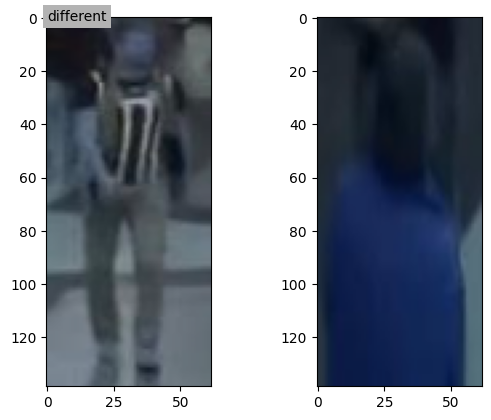

In [9]:
batch = next(iter(test_loader))
x1, x2, actual_distance = batch[0][0], batch[1][0], batch[2][0]
display_images((x1, x2), actual_distance)

## Подсчет метрик

In [14]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [46]:
model = model.to(device)
# model = SiameseBasicCNN().to(device)
distances = []
for x1, x2, y in tqdm(test_loader):
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    # нам не нужно считать градиент для предсказания
    with torch.no_grad():
        d = model(x1, x2).item()
    # убираем из видеопамяти
    distances.append(d)
    # удаляем
    del d
    # очищаем кэш
    torch.cuda.empty_cache()
    # d = 1 if (d > threshold) else 0

# acc = acc / len(test_loader)

100%|██████████| 6946/6946 [00:24<00:00, 284.45it/s]


In [47]:
distances = np.array(distances)
# distances[1]

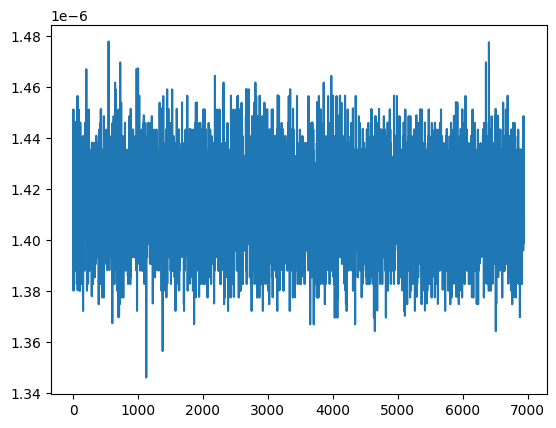

In [48]:
plt.plot(distances)

In [27]:
distances.min(), distances.max()

(1.204217142003472e-06, 1.6254942920568283e-06)

In [30]:
distances = preprocessing.normalize([distances])

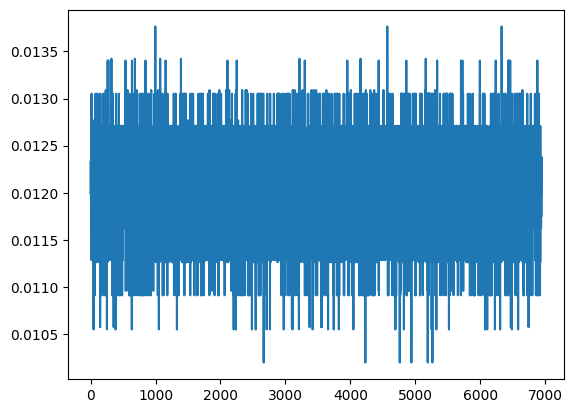

In [34]:
plt.plot(distances[0])

In [44]:
best

,model_name,datetime,epoch_count,optimizer,lr,gamma,step_size,loss_name,val_losses,val_accuracies,best_val_acc,best_val_loss,test_accuracy,dataset_config,extra_parameters,train_losses,train_accuracies
7,basic_cnn,2023-05-17 15:03:13.436258,6,Adam,0.01,0.1,2.0,ContrastiveLoss m=1.5,0.9714098906517029;0.8796071553230286;0.881902...,0.8275;0.9425;0.925;0.9175;0.9025;0.8925,0.9425,0.866354,NaN,mot20_ext-v1c,threshold=0.25,NaN,NaN


In [42]:
val_accuracies = list(map(float, best['val_accuracies'].item().split(';')))
val_losses = list(map(float, best['val_losses'].item().split(';')))
epoch_count = int(best['epoch_count'].item())

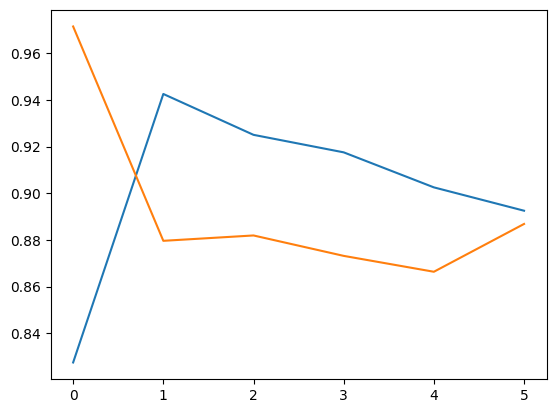

In [43]:
plt.plot(range(epoch_count), val_accuracies, val_losses)